In [1]:
from DistantSpeech.beamformer.utils import load_audio
from scipy.signal import convolve as conv
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from DistantSpeech.adaptivefilter import BaseFilter, FastFreqLms, awgn
from DistantSpeech.adaptivefilter.RLS import Rls
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite

(336567,)


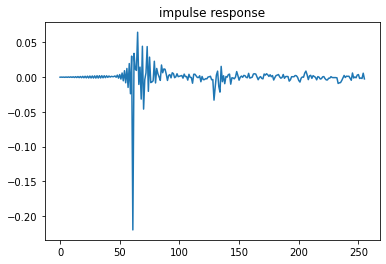

In [2]:
# load source single and rir
src = load_audio('/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav')
src = np.random.rand(len(src))-0.5# * np.sqrt(npower)
print(src.shape)
rir = load_audio('/home/wangwei/work/DistantSpeech/DistantSpeech/adaptivefilter/rir.wav')
rir = rir[200:]

filter_len = 256

rir = rir[:filter_len, np.newaxis]
plt.figure()
plt.plot(rir)
plt.title('impulse response')
plt.show()

(336567,)
(336567,)


100%|██████████| 336311/336311 [11:56<00:00, 469.25it/s]


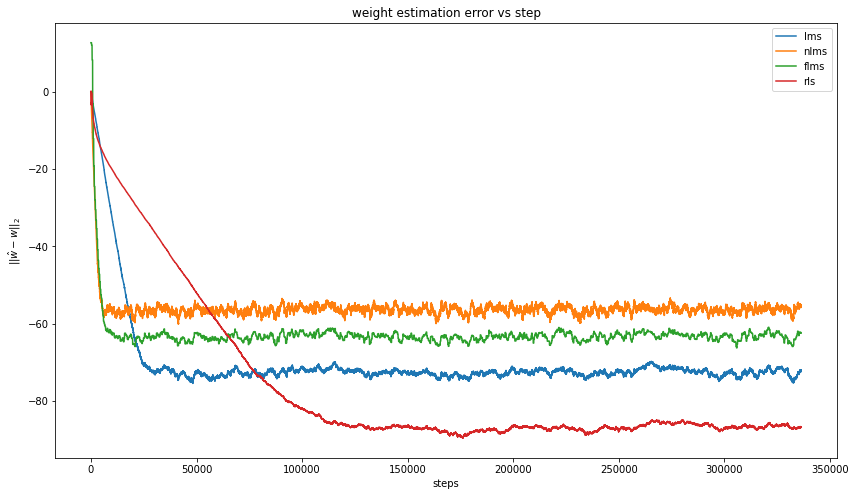

In [3]:


# src = awgn(src, 30)

SNR = 15
data_clean = conv(src, rir[:, 0])
data = data_clean[:len(src)]
data = awgn(data, SNR)

print(src.shape)
print(data.shape)

# array_data = audioread("/home/wangwei/work/DistantSpeech/example/mix.wav")
# src = array_data[:, 0]
# data = array_data[:, 1]

w = np.zeros((filter_len, 1))

lms = BaseFilter(filter_len=filter_len, mu=0.001, normalization=False)
nlms = BaseFilter(filter_len=filter_len, mu=0.1)
flms = FastFreqLms(filter_len=filter_len, mu=0.1)
rls = Rls(filter_len=filter_len, mu=0.1)

valid_len = len(src)-flms.filter_len  # discard last frame

est_err_lms = np.zeros(valid_len)
est_err_nlms = np.zeros(valid_len)
est_err_flms = np.zeros(valid_len)
est_err_rls = np.zeros(valid_len)

output = np.zeros(data.shape)

for n in tqdm(range((valid_len))):
    if np.mod(n, flms.filter_len) == 0:
        input_vector = src[n: n +  flms.filter_len]
        d_vector = data[n : n + flms.filter_len]
        err, w_flms = flms.update(input_vector, d_vector)

        output[n : n + flms.filter_len] = err[:, 0]
    _, w_lms = lms.update(src[n], data[n])
    _, w_nlms = nlms.update(src[n], data[n])
    _, w_rls = rls.update(src[n], data[n])
    est_err_lms[n] = np.sum(np.abs(rir - w_lms[:len(rir)])**2)
    est_err_nlms[n] = np.sum(np.abs(rir - w_nlms[:len(rir)])**2)
    est_err_flms[n] = np.sum(np.abs(rir - w_flms[:len(rir)])**2)
    est_err_rls[n] = np.sum(np.abs(rir - w_rls[:len(rir)])**2)

plt.figure(figsize=(14,8))
plt.plot(10 * np.log(est_err_lms / np.sum(np.abs(rir[:, 0])**2) + 1e-6))
plt.plot(10 * np.log(est_err_nlms / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.plot(10 * np.log(est_err_flms / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.plot(10 * np.log(est_err_rls / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.legend(['lms', 'nlms', 'flms', 'rls'], loc='upper right')
plt.xlabel("steps")
plt.ylabel("$\||\hat{w}-w\||_2$")
plt.title('weight estimation error vs step')
plt.show()

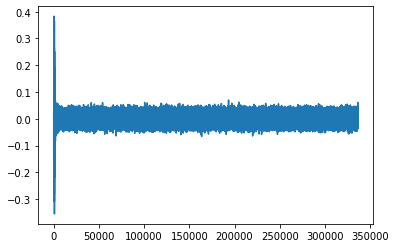

In [4]:
plt.figure()
plt.plot(output)
plt.show()
# audiowrite('flms1.wav', output)